# Setup

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/ssh_AVISO/'
infn = 'all_adt_sla_global_twosat_phy_l4_vDT2018_daily_1994_2018.nc'

ds = xr.open_dataset(path + infn)
#print(ds.keys())

# Subset ------------------------------------------------#

# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(40, 100) # bounds inclusive

# Get data, selecting lat/lon slice
daily_sla = ds['sla'].sel(latitude=lat_slice,longitude=lon_slice)
lat = daily_sla.latitude.values
lon = daily_sla.longitude.values

# Create Grid -------------------------------------------#

# convert to a grid
[lon_grid, lat_grid] = np.meshgrid(lon,lat)

In [2]:
ds

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 720, longitude: 1440, time: 9131)
Coordinates:
  * time            (time) datetime64[ns] 1994-01-01 1994-01-02 ... 2018-12-31
  * longitude       (longitude) float32 0.125 0.375 0.625 ... 359.625 359.875
  * latitude        (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
Dimensions without coordinates: bnds
Data variables:
    longitude_bnds  (longitude, bnds) float32 ...
    latitude_bnds   (latitude, bnds) float32 ...
    crs             int32 ...
    adt             (time, latitude, longitude) float64 ...
    sla             (time, latitude, longitude) float64 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.8 (ht...
    Conventions:                     CF-1.6
    history:                         Mon Jun 29 12:37:33 2020: cdo copy -sele...
    source:                          Altimetry measurements
    institution:                     CLS, CNES
    Metadata_Conventions:      

# Find Coastlines

[ 80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  81  81  82  82  83  83  83  84  84  85
  85  86  86  87  87  87  88  88  88  88  89  89  9

Text(0.5, 1.0, 'Unordered Stations')

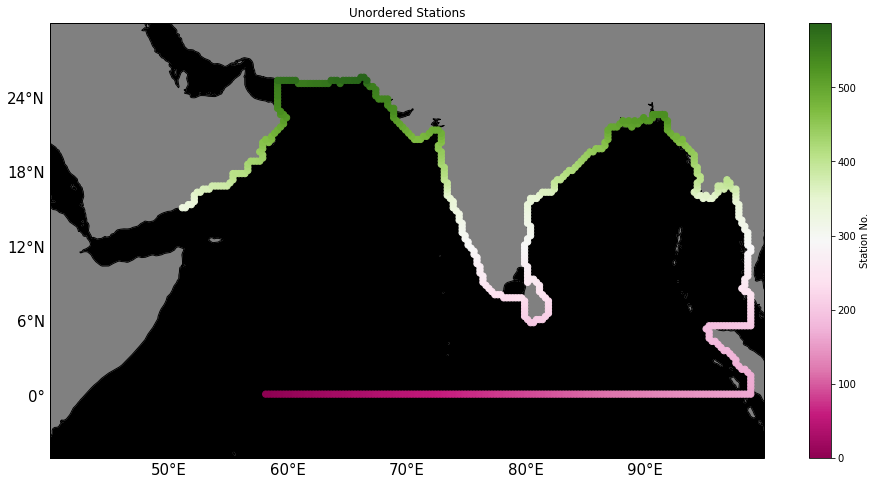

In [5]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = daily_sla[0,:,:]
xx,yy = np.meshgrid(lon,lat)
# set Gulfs to Nans
mask = mask.where(~((yy>22) & (xx<59)))
mask = mask.where(~((yy>10) & (xx<51)))

# AS inlets
mask = mask.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)))
mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# sri lanka are
mask = mask.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80)))

# Sumatra area
mask = mask.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<100)))
mask = mask.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)))
mask = mask.where(~((yy>0) & (yy<10) & (xx>99) & (xx<100)))
mask = mask.where(~((yy>0) & (yy<2.5) & (xx>97) & (xx<98)),1)

# equator
mask = mask.where(~(yy<0))
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))
print(sta_latinds_unord)
# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[60:]
sta_loninds_unord = sta_loninds_unord[60:]

# AS
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~(lons_from_sta >99)
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [40,100,-5,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

In [7]:
lon.max

(240,)

In [ ]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#


def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

EQ = 0
JA = 89
sBoB = 210
mBoB = 300
SL = 390
mAS = 500
eAS = 582
loc_list = [EQ,JA,sBoB,mBoB,SL,mAS,eAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
bounds = [40,100,-5,30]

def add_land(ax,bounds):
    res = '50m'
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    land = cfeature.NaturalEarthFeature('physical', 'land', res,
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
    ax.add_feature(land,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution=res,zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# xx,yy = np.meshgrid(lon,lat)
# plt.scatter(xx.flatten(),yy.flatten(),s = 160,c='w',marker = '.')
p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
            s = 160,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
            s = 260,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Ordered Stations')

# Detrend SLA

Resources: [link](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Example_calculations_with_scalar_quantities.html), [link](https://groups.google.com/g/xarray/c/fz7HHgpgwk0), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/28647172/numpy-polyfit-doesnt-handle-nan-values), [link](https://stackoverflow.com/questions/17638137/curve-fitting-to-a-time-series-in-the-format-datetime)


In [ ]:
# stack lat and lon into a single dimension called allpoints
stacked = daily_sla.stack(allpoints=['latitude','longitude'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
daily_sla_slope, daily_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
daily_sla_slope = np.reshape(daily_sla_slope, daily_sla.shape[1:3])
daily_sla_intercept = np.reshape(daily_sla_intercept, daily_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
daily_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
daily_sla_dtrnd = daily_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
daily_sla_dtrnd = daily_sla_dtrnd.where(~np.isnan(daily_sla))

# make plot for this to show difference..

# Downsample to Monthly and Seasonal Temporal Resolution

In [ ]:
# monthly
mon_sla_dtrnd = daily_sla_dtrnd.resample(time='1MS').mean(dim="time")
# seasonal
seas_sla_dtrnd = daily_sla_dtrnd.resample(time='QS-DEC').mean(dim="time")

# Find Climatologies 
Resources: [link](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

In [ ]:
# -------------------------------------------
# weighted seasonal
# -------------------------------------------

# all data
month_length = daily_sla_dtrnd.time.dt.days_in_month

# calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# calculate the weighted average
sla_seas_clim_dtrnd = (daily_sla_dtrnd * weights).groupby('time.season').sum(dim='time')   

# set the places that are now zero from the weights to nans
sla_seas_clim_dtrnd = sla_seas_clim_dtrnd.where(sla_seas_clim_dtrnd != 0,np.nan) # for some reason .where sets the locations not in the condition to nan by default

# -------------------------------------------
# monthly
# -------------------------------------------

# all data
sla_mon_clim_dtrnd = daily_sla_dtrnd.groupby('time.month').mean('time') 


# Find Anomalies

In [ ]:
# daily data - monthly climatology
daily_sla_mon_anom_dtrnd = daily_sla_dtrnd.groupby('time.month') - sla_mon_clim_dtrnd

# monthly avg data - monthly climatology
mon_sla_mon_anom_dtrnd = mon_sla_dtrnd.groupby('time.month') - sla_mon_clim_dtrnd

# Group Anomalies Into IOD Phases

In [ ]:
# eventually build some code to identify this yourself to include the years you couldn't find papers for

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = [1994,1997,2006,2012,2015]
# posIODwENSOyears = ['1997']
negIODyears = [1996,1998,2001,2010,2014,2016]
# negIODwENSOyears = ['1998']
neuIODyears = [1995,1999,2000,2002,2003,2004,2005,2007,2008,
               2009,2011,2012,2013]

# average over the positive IOD years -------------------------------------------# 
daily_data = []
mon_data = []
mon_clim = []
for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-03-01'
    end_time = str(year+1) + '-02-28'
    time_slice = slice(start_time, end_time)
    daily_data.append(daily_sla_mon_anom_dtrnd.sel(time=time_slice))
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(time=time_slice))
    
posIOD_daily_sla_mon_anom_dtrnd = xr.concat(daily_data, dim='time')

# add all the data together
posIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='time')
# take the mean for each month of all the years
posIOD_mon_sla_mon_anom_dtrnd = posIOD_mon_sla_mon_anom_dtrnd.groupby('time.month').mean(dim='time')
#start in march instead of 01
posIOD_mon_sla_mon_anom_dtrnd =posIOD_mon_sla_mon_anom_dtrnd.roll(month=-2,roll_coords = False)

# average over the negative IOD years -------------------------------------------# 
daily_data = []
mon_data = []
for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-03-01'
    end_time = str(year+1) + '-02-28'
    time_slice = slice(start_time, end_time)
    daily_data.append(daily_sla_mon_anom_dtrnd.sel(time=time_slice))
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(time=time_slice))
    
negIOD_daily_sla_mon_anom_dtrnd = xr.concat(daily_data, dim='time')

negIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='time')
negIOD_mon_sla_mon_anom_dtrnd = negIOD_mon_sla_mon_anom_dtrnd.groupby('time.month').mean(dim='time')
negIOD_mon_sla_mon_anom_dtrnd =negIOD_mon_sla_mon_anom_dtrnd.roll(month=-2,roll_coords = False)

# average over the neutral IOD years -------------------------------------------# 
daily_data = []
mon_data = []
for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-03-01'
    end_time = str(year+1) + '-02-28'
    time_slice = slice(start_time, end_time)
    daily_data.append(daily_sla_mon_anom_dtrnd.sel(time=time_slice))
    mon_data.append(mon_sla_mon_anom_dtrnd.sel(time=time_slice))
    
neuIOD_daily_sla_mon_anom_dtrnd = xr.concat(daily_data, dim='time')

neuIOD_mon_sla_mon_anom_dtrnd = xr.concat(mon_data, dim='time')
neuIOD_mon_sla_mon_anom_dtrnd = neuIOD_mon_sla_mon_anom_dtrnd.groupby('time.month').mean(dim='time')
neuIOD_mon_sla_mon_anom_dtrnd = neuIOD_mon_sla_mon_anom_dtrnd.roll(month=-2,roll_coords = False)

# Hovmueller Diagrams for 0.25 Degree

## Interannual Data

In [ ]:
# create list of integer years
IODphases = list([posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 14})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(18, 8))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['03', '04', '05','06','07','08','09','10','11','12','01','02'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','JA', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')


## Seasonal

In [ ]:
# create list of integer years
rolled_ann_cyc = sla_mon_clim_dtrnd.roll(month=-2,roll_coords = False)
IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 12})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(20, 8))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,4,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['03', '04', '05','06','07','08','09','10','11','12','01','02'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','JA', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')



In [ ]:
# create list of integer years

IODphases = list([rolled_ann_cyc,posIOD_mon_sla_mon_anom_dtrnd,negIOD_mon_sla_mon_anom_dtrnd,neuIOD_mon_sla_mon_anom_dtrnd])
titles = ['Annual Cycle','Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 12})

cmin = -0.15
cmax = 0.15

fig = plt.figure(figsize=(20, 8))
for ii,phase in enumerate(IODphases):
    diff_var = np.sign(phase) + np.sign(rolled_ann_cyc)
    
    # Get times and make array of datetime objects
    vtimes = phase.month
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    diff_data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    

    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]
        diff_data[:,jj] = diff_var[:,sta_latinds[jj],sta_loninds[jj]]
        
    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(2,4,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
    ax.set_yticklabels(['03', '04', '05','06','07','08','09','10','11','12','01','02'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','JA', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.
        
    ax = fig.add_subplot(2,4,ii+5)

    # Plot of chosen variable averaged over latitude and slightly smoothed
#     cf = ax.contourf(sta,vtimes,diff_data,levels = np.array([-1,-0.0001,0.0001,1]),cmap=plt.cm.PuOr_r, extend="both")
    ax.pcolormesh(sta,vtimes,diff_data,cmap = plt.cm.coolwarm)
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
    ax.set_yticklabels(['03', '04', '05','06','07','08','09','10','11','12','01','02'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','JA', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')




# Annual Cycle

In [ ]:
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = rolled_ann_cyc.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

In [ ]:
# posIOD
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = posIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

In [ ]:
# negIOD
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = negIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

In [ ]:
# neuIOD
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = neuIOD_mon_sla_mon_anom_dtrnd.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        vmax=0.15,vmin=-0.15, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
                                        cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')
#     plt.subplots_adjust(top=.9)

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

# Differences between annual cycle and positive IOD years

In [ ]:
# posIOD

var = np.sign(posIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')

In [ ]:
# negIOD

var = np.sign(negIOD_mon_sla_mon_anom_dtrnd) + np.sign(rolled_ann_cyc)
months = ['Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb']

p = var.plot.pcolormesh(x="longitude", y="latitude", col="month", col_wrap=3,
                                        cmap="PuOr_r",
                                        add_colorbar=False,
                                        vmax=1,vmin=-1, # set colorbar lims
                                        extend = 'neither', # make a box colorbar rather than pointed
                                        figsize = (12, 12),
#                                         cbar_kwargs={"label": "Sea Level Anomaly (m)"},
                                        subplot_kws={'facecolor': 'gray'}
                                       )

for i, ax in enumerate(p.axes.flat):
    ax.set_title(months[i])
    ax.axes.axis('tight')

p.set_xlabels('Longitude')
p.set_ylabels('Latitude')

cmap=plt.cm.PuOr

custom_lines = [Line2D([0], [0], color=cmap(0.), lw=4),
                Line2D([0], [0], color=cmap(.5), lw=4),
                Line2D([0], [0], color=cmap(1.), lw=4)]

# ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],bbox_to_anchor=(-.7, -0.5), loc='center',
#          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
leg = ax.legend(custom_lines, ['Posititve', 'Opposite', 'Negative'],loc='center',
          bbox_to_anchor = (0.02,-0.55,1,1),bbox_transform = plt.gcf().transFigure,
          ncol = 3,handlelength=5, borderpad=1.2, labelspacing=1.2)
frame = leg.get_frame()
frame.set_facecolor('lightgray')

In [ ]:
# manually remove some points

# remove lower boundary (about 10N)
loninds = loninds[latinds>120]
latinds = latinds[latinds>120]

BoB_latinds = latinds
BoB_loninds = loninds

BoB_latinds = BoB_latinds[(BoB_loninds>195) & (BoB_loninds<276)]
BoB_loninds = BoB_loninds[(BoB_loninds>195) & (BoB_loninds<276)]
    
AS_latinds = latinds
AS_loninds = loninds

AS_latinds = AS_latinds[(AS_loninds>119) & (AS_loninds<195)]
AS_loninds = AS_loninds[(AS_loninds>119) & (AS_loninds<195)]

# EQ_latinds
# EQ_loninds

In [ ]:
#BoB

BoB_sta_zero = (274,121) # 98.625, 10.375
BoB_sta_lonind, BoB_sta_latind =order_coast_BoB(BoB_loninds,BoB_latinds,BoB_sta_zero)

In [ ]:
#AS
# take first piece
AS_sta_zero = (184,121) # 76.125, 10.375
AS_sta_lonind, AS_sta_latind =order_coast_AS(AS_loninds,AS_latinds,AS_sta_zero)
AS_sta_lonind = AS_sta_lonind[:-8]
AS_sta_latind = AS_sta_latind[:-8]

In [ ]:
# get data from tigress
path = '/home/jennap/projects/LRGROUP/shared_data/IOD_index/'
infn = 'dmi_updated_10_07_2020.nc'

dmi_ds = xr.open_dataset(path + infn)

https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2007JD009151
http://www.bom.gov.au/climate/iod/

In [ ]:
var = sla_mon_clim_mon

# average over the positive IOD years
data = []
for ii,year in enumerate(posIODyears):
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    time_slice = slice(start_time, end_time)
    data.append(var.sel(time=time_slice))
combined = xr.concat(data, dim='time')
posIODdata = combined.groupby('time.month').mean(dim='time')


# average over the negative IOD years
data = []
for ii,year in enumerate(negIODyears):
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    time_slice = slice(start_time, end_time)
    data.append(var.sel(time=time_slice))
combined = xr.concat(data, dim='time')
negIODdata = combined.groupby('time.month').mean(dim='time')



# average over the neutral IOD years
data = []
for ii,year in enumerate(neuIODyears):
    start_time = year +'-01-01'
    end_time = year+'-12-31'
    time_slice = slice(start_time, end_time)
    data.append(var.sel(time=time_slice))
combined = xr.concat(data, dim='time')
neuIODdata = combined.groupby('time.month').mean(dim='time')

